In [ ]:
#Path where this script and the sentence vec model is
%cd gdrive/My\ Drive/Shivani
%ls

In [ ]:
!pip install sent2vec-prebuilt

In [ ]:
!pip install xgboost

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

### Initialisation
* Start execution from here if not on Google Colab*

In [ ]:
!pip install scipy==1.1.0

In [ ]:
!pip install scikit-learn==0.21.3

In [ ]:
!pip uninstall sent2vec

In [1]:
#importing relevant libraries
import sent2vec
from nltk import word_tokenize
import nltk
import pandas as pd
import csv
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
import json

In [2]:
#Change the path according to location of file in the computer
model_path = "BioSentVec_PubMed_MIMICIII-bigram_d700.bin"
model = sent2vec.Sent2vecModel()

In [3]:
#Loading of model might throw an exception, retry running the code or check if computer has suffficient RAM
try:
  model.load_model(model_path)
except Exception as e:
  print(e)

------------------------------
### Preprocessing

In [4]:
stop_words = set(stopwords.words('english'))

def preprocess_sentence(text):
    #Basic NLP word tokenisation and cleaning
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()
    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
    return ' '.join(tokens)

In [5]:
df = pd.read_csv("./../Final Annotations.csv")

train_df = df.sample(frac=0.75,random_state=0)
df = df.drop(train_df.index)

test_df = df

train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [6]:
## EMBEDDING LOADER

train_vector = []
train_labels = []
for i in tqdm(range(len(train_df))):
    train_df["Abstracts"][i] = preprocess_sentence(train_df["Abstracts"][i])
    sentence_vec = model.embed_sentence(train_df["Abstracts"][i])
    train_vector.append(sentence_vec)
    train_labels.append(int(train_df["Labels"][i]))
    
test_vector = []
test_labels = []
for i in tqdm(range(len(test_df))):
    test_df["Abstracts"][i] = preprocess_sentence(test_df["Abstracts"][i])
    sentence_vec = model.embed_sentence(test_df["Abstracts"][i])
    test_vector.append(sentence_vec)
    test_labels.append(int(test_df["Labels"][i]))

  0%|          | 0/1574 [00:00<?, ?it/s]/home/shivaniku/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
  0%|          | 0/525 [00:00<?, ?it/s]/home/shivaniku/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 525/525 [00:12<00:00, 43.17it/s]


In [7]:
X_train, X_test, y_train, y_test = [], [], [], []

for vec,lab in tqdm(zip(train_vector, train_labels)):
#     X_train.append(vec.numpy())
    X_train.append(vec[0])
    y_train.append(lab)

for vec,lab in tqdm(zip(test_vector, test_labels)):
#     X_test.append(vec.numpy())
    X_test.append(vec[0])
    y_test.append(lab)

1574it [00:00, 256461.60it/s]
525it [00:00, 215608.50it/s]


##### Visualising

In [8]:
X = X_train + X_test
y = y_train + y_test
df = pd.DataFrame(X)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

In [9]:
df.shape

(2099, 702)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.08583427 0.05618957]


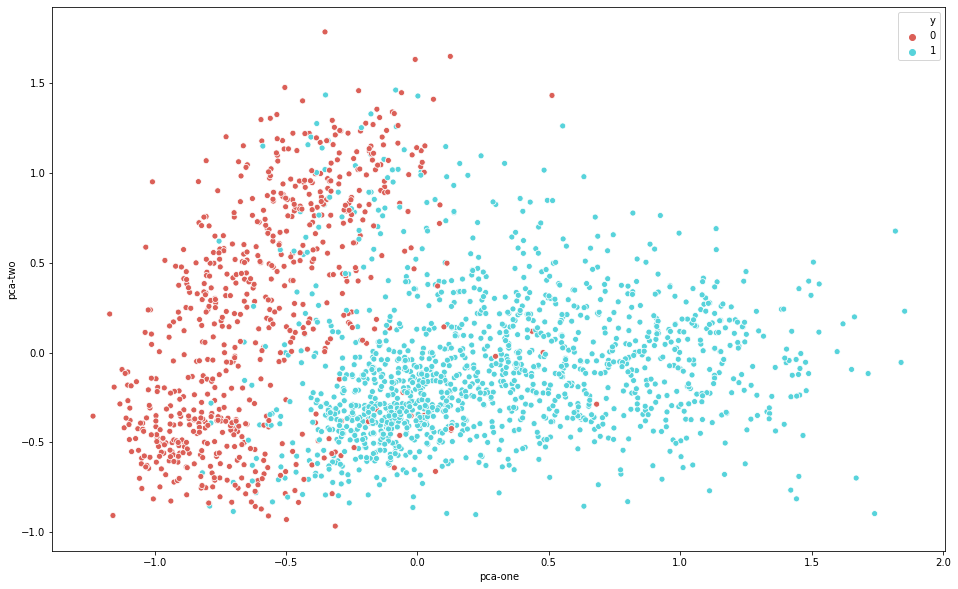

In [11]:
rndperm = np.random.permutation(df.shape[0])

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df["pca-one"], y=df["pca-two"],
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=1.0
)
plt.show()

----------------------
### Training

In [12]:
# Feature Scaling for more better training
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##### SVM

In [ ]:
# Fitting SVC to the Training set
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
kf = KFold(n_splits=5)
svc = SVC()
parameters = [
    {'kernel': 'poly', 'degree': 1, 'C': 1}, 
    {'kernel': 'poly', 'degree': 1, 'C': 2}, 
    {'kernel': 'poly', 'degree': 1, 'C': 3}, 
    {'kernel': 'poly', 'degree': 2, 'C': 1}, 
    {'kernel': 'poly', 'degree': 2, 'C': 2},
    {'kernel': 'poly', 'degree': 2, 'C': 3}, 
    {'kernel': 'poly', 'degree': 3, 'C': 1},
    {'kernel': 'poly', 'degree': 3, 'C': 2},
    {'kernel': 'poly', 'degree': 3, 'C': 3},
    {'kernel': 'poly', 'degree': 4, 'C': 1},
    {'kernel': 'poly', 'degree': 4, 'C': 2},
    {'kernel': 'poly', 'degree': 4, 'C': 3},
    {'kernel': 'rbf', 'C': 1},
    {'kernel': 'rbf', 'C': 2},
    {'kernel': 'rbf', 'C': 3},
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'linear', 'C': 2},
    {'kernel': 'linear', 'C': 3},
    {'kernel': 'sigmoid', 'C': 1},
    {'kernel': 'sigmoid', 'C': 2},
    {'kernel': 'sigmoid', 'C': 3}
]

In [ ]:
scores = [0]*len(parameters)
for train_index, val_index in kf.split(X_train):
    X_ktrain, X_val = X_train[train_index], X_train[val_index]
    y_ktrain, y_val = y_train[train_index], y_train[val_index]
    cnt = 0
    for param in tqdm(parameters):
        if param['kernel'] == 'poly':
            classifier = SVC(kernel = 'poly', degree=param['degree'], C = param['C'],
                             random_state = 0, gamma = "auto", probability = True)
        else:
            classifier = SVC(kernel = param['kernel'], C = param['C'],
                             random_state = 0, gamma = "auto", probability = True)
        classifier.fit(X_ktrain, y_ktrain)
        y_pred = classifier.predict_proba(X_val)
        y = []
        for i in range(len(y_pred)):
            if y_pred[i][1]>0.7:
                y.append(1)
            else:
                y.append(0)
        y_pred = y
        scores[cnt] += cohen_kappa_score(y_val, y_pred, labels=None, weights=None, sample_weight=None)
        cnt += 1

In [ ]:
scores = np.array(scores)/5

In [ ]:
[(parameters[i], scores[i]) for i in range(len(scores))]

# K-folds

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

scores_svc = [0]*5
scores_xg = [0]*5
scores_lr = [0]*5

scores_svc_test = [0]*5
scores_xg_test = [0]*5
scores_lr_test = [0]*5

kf = KFold(n_splits=5, shuffle=True)
cnt = 0
    
for train_index, val_index in kf.split(X_train):
    X_ktrain, X_val = X_train[train_index], X_train[val_index]
    y_ktrain, y_val = y_train[train_index], y_train[val_index]
    
    # SVC
    print("SVC")
    classifier = SVC(kernel = 'poly', degree=3, random_state = 0, gamma = "auto", probability = True,class_weight='balanced')
    classifier.fit(X_ktrain, y_ktrain)
    
    y_kpred = classifier.predict_proba(X_val)
    y_kscore = classifier.decision_function(X_val)

    y = []
    for i in range(len(y_kpred)):
        if y_kpred[i][1]>0.7:
            y.append(1)
        else:
            y.append(0)
    y_kpred = y
    
    print("VAL")
    print(classification_report(y_val,y_kpred))
    print(cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None))
    scores_svc[cnt] = cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None)
    
    y_pred = classifier.predict_proba(X_test)
    y_score = classifier.decision_function(X_test)

    y = []
    for i in range(len(y_pred)):
        if y_pred[i][1]>0.7:
            y.append(1)
        else:
            y.append(0)
    y_pred = y
    
    print("TEST")
    print(classification_report(y_test,y_pred))
    print(cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
    scores_svc_test[cnt] = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)
    
    # xgboost
    print("XGBoost")
    classifier = XGBClassifier()
    classifier.fit(X_ktrain, y_ktrain)
    
    y_kscore = classifier.predict(X_val)
    y_kpred = [round(value) for value in y_kscore]
    
    print("VAL")
    print(classification_report(y_val,y_kpred))
    print(cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None))
    scores_xg[cnt] = cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None)
    
    y_score = classifier.predict(X_test)
    y_pred = [round(value) for value in y_score]
    
    print(classification_report(y_test,y_pred))
    print(cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
    scores_xg_test[cnt] = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)
    
    # LR
    print("LR")
    classifier = LogisticRegression(random_state=0).fit(X_ktrain, y_ktrain)
    
    y_kpred = classifier.predict_proba(X_val)
    y_kscore = classifier.decision_function(X_val)

    y = []
    for i in range(len(y_kpred)):
        if y_kpred[i][1]>0.7:
            y.append(1)
        else:
            y.append(0)
    y_kpred = y
    
    print("VAL")
    print(classification_report(y_val,y_kpred))
    print(cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None))
    scores_lr[cnt] = cohen_kappa_score(y_val, y_kpred, labels=None, weights=None, sample_weight=None)
    
    y_pred = classifier.predict_proba(X_test)
    y_score = classifier.decision_function(X_test)

    y = []
    for i in range(len(y_pred)):
        if y_pred[i][1]>0.7:
            y.append(1)
        else:
            y.append(0)
    y_pred = y
    
    print("TEST")
    print(classification_report(y_test,y_pred))
    print(cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
    scores_lr_test[cnt] = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)

    cnt += 1

In [ ]:
print(scores_svc)
print(scores_xg)
print(scores_lr)
print()
print(scores_svc_test)
print(scores_xg_test)
print(scores_lr_test)

### End of current code

##### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

##### MLP

In [13]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(random_state=1, max_iter=300)
classifier.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=1)

##### SVM

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

classifier = SVC(kernel = 'poly', degree=3, random_state = 0, gamma = "auto", probability = True,class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)
y_score = classifier.decision_function(X_test)

y = []
for i in range(len(y_pred)):
    if y_pred[i][1]>0.7:
        y.append(1)
    else:
        y.append(0)
y_pred = y
kappa = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)

print(classification_report(y_test,y_pred))
print(kappa)

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       175
           1       0.95      0.94      0.95       350

    accuracy                           0.93       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.93      0.93      0.93       525

0.8425531914893617


In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', probability = True)
classifier.fit(X_train, y_train)

In [ ]:
filename = 'svm_classification_model-{}-{}.pickle'.format(len(pos_df),len(neg_df))
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
classifier.cv_results_

##### XGBoost

In [63]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

/home/shivaniku/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [33]:
filename = 'xgboost_classification_model-BioSentVec.pickle'
pickle.dump(classifier, open(filename, 'wb'))

##### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0).fit(X_train, y_train)

/home/shivaniku/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
filename = 'lr_classification_model-{}-{}.pickle'.format(len(pos_df),len(neg_df))
pickle.dump(classifier, open(filename, 'wb'))

--------------------------------
### Predicting on test set

##### SVM

In [18]:
y_pred = classifier.predict_proba(X_test)
y_score = classifier.decision_function(X_test)

y = []
for i in range(len(y_pred)):
    if y_pred[i][1]>0.7:
        y.append(1)
    else:
        y.append(0)
y_pred = y

##### XGBoost

In [64]:
classifier.predict_proba(X_test)

array([[1.0499358e-03, 9.9895006e-01],
       [4.2945743e-03, 9.9570543e-01],
       [4.0145516e-03, 9.9598545e-01],
       ...,
       [8.4098160e-01, 1.5901837e-01],
       [8.9264500e-01, 1.0735497e-01],
       [9.9910605e-01, 8.9396042e-04]], dtype=float32)

In [34]:
y_score = classifier.predict(X_test)
y_pred = [round(value) for value in y_score]

##### Logistic Regression

In [27]:
y_pred = classifier.predict_proba(X_test)
y_score = classifier.decision_function(X_test)

y = []
for i in range(len(y_pred)):
    if y_pred[i][1]>0.7:
        y.append(1)
    else:
        y.append(0)
y_pred = y

##### Random Forest

In [14]:
y_pred = classifier.predict_proba(X_test)

y = []
for i in range(len(y_pred)):
    if y_pred[i][1]>0.7:
        y.append(1)
    else:
        y.append(0)
y_pred = y

##### MLP

In [14]:
y_pred = classifier.predict_proba(X_test)

y = []
for i in range(len(y_pred)):
    if y_pred[i][1]>0.7:
        y.append(1)
    else:
        y.append(0)
y_pred = y

##### General

In [15]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[156  19]
 [ 20 330]]


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
print("For the classifier: ",classifier)

acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
prec = precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
rec = recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
f1 = f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
kappa = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)

print("Accuracy = ",acc)
print("Precision = ",prec)
print("Recall = ",rec)
print("F1 = ",f1)
print("Cohen's Kappa = ",kappa)

For the classifier:  MLPClassifier(max_iter=300, random_state=1)
Accuracy =  0.9257142857142857
Precision =  0.9455587392550143
Recall =  0.9428571428571428
F1 =  0.944206008583691
Cohen's Kappa =  0.833095577746077


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
print("For the classifier: ",classifier)

acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

kappa = cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)

print("Accuracy = ",acc)

print("Cohen's Kappa = ",kappa)

For the classifier:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)
Accuracy =  0.9314285714285714
Cohen's Kappa =  0.8452722063037249


In [39]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
print(fpr)
print(tpr)

[0.         0.10857143 1.        ]
[0.         0.95142857 1.        ]


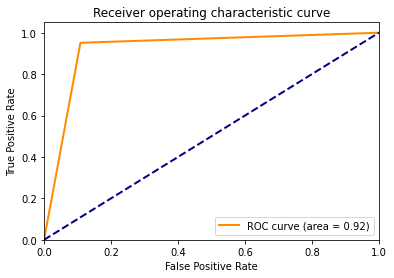

In [62]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

In [47]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(precision, recall)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

ImportError: cannot import name 'PrecisionRecallDisplay'

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

ImportError: cannot import name 'plot_precision_recall_curve'

In [44]:
!pip freeze | grep sklearn

sklearn==0.0


In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class ROC curve')

ImportError: cannot import name 'plot_roc_curve'

--------------------------
### Inferencing

In [ ]:
##Change name of classifier accordingly
filename = 'classification_model.pickle'
classifier = pickle.load(open(filename, 'rb'))

In [ ]:
data_path = "./2019_merged_json_fixed/"
selected_abstracts = []
for f in os.listdir(data_path):
  with open(data_path+f,'rb') as jf:
    data = jf.readlines()
  for line in data:
    datajson = json.loads(line)
    if datajson['abstract'] != "":
      abstract = preprocess_sentence(datajson['abstract'])
      sentence_vec = model.embed_sentence(abstract)
      result = classifier.predict_proba(sentence_vec)
      print("RESULT --> ",result)
      if result[0][1] > 0.7:
        print("***SELECTED***")
        selected_abstracts.append(datajson)       #Whole json is being appended instead of just PMIDs; Can change to just PMIDs?

In [ ]:
##Save the selected_abstracts list properly

### Extras

In [ ]:
from sklearn.decomposition import PCA
import pylab as pl
import numpy as np

pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)
svmClassifier_2d = SVC(kernel = 'poly', degree=3, random_state = 0, gamma = "auto", probability = True,class_weight='balanced').fit(pca_2d, y_train)
for i in range(0, pca_2d.shape[0]):
  if y_train[i] == 0:
    c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=20,marker='+',alpha=0.7)
  elif y_train[i] == 1:
    c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', s=20,marker='o',alpha=0.7)

pl.legend([c1, c2], ['Negative', 'Positive'])
x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))

Z = svmClassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)
pl.contour(xx, yy, Z)
pl.title('Support Vector Machine Decision Surface')
pl.axis('off')
pl.show()